# Data Cleaning for Our Dataset
### Evan Schubert
### CSC 2621-141
### Created on: 04/10/2025

**What Each Column Represents**<br>
**Transaction_ID** - arbitrary unique ID given to each transaction<br>
**User_ID** - The unique identifier for each user<br>
**Transaction Amount** - amount of money transacted<br>
**Transaction Type** - ATM withdrawal, Bill Payment, POS payment, bank transfer, online purchase<br>
**Time of Transaction** - Military time for the time the transaction occured, 0 through 23<br>
**Device Used** - Tablet, mobile, desktop, unknown device<br>
**Location** - San Francisco, New York, Chicago, Boston, Houston, Miami, Los Angeles, Seattle<br>
**Previous Fraudulent Transactions** - How many previous fraudelent transactions does this user have, 0 through 4<br>
**Age** - How long the account has been active in possibly months, 0 through 119<br>
**Number of Transactions last 24H**- The number of transactions in the last 24 hours for this user, 1 through 14<br>
**Payment Method** - Debit card, credit card, UPI, net banking, invalid method<br>
**Fraudulent** - boolean representing whether the transaction was fraudulent.<br>

In [102]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import stats, linregress, kruskal, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

fraud_df = pd.read_csv("Fraud Detection Dataset.csv")

In [2]:
## Calculate na percantages for each column
nan_counts = 100 * fraud_df.isna().sum() / len(fraud_df)
total_nan = fraud_df.isna().any(axis=1).sum()
print(nan_counts)
print(total_nan)
print(100 * total_nan / len(fraud_df))

Transaction_ID                      0.000000
User_ID                             0.000000
Transaction_Amount                  4.941176
Transaction_Type                    0.000000
Time_of_Transaction                 5.003922
Device_Used                         4.849020
Location                            4.994118
Previous_Fraudulent_Transactions    0.000000
Account_Age                         0.000000
Number_of_Transactions_Last_24H     0.000000
Payment_Method                      4.841176
Fraudulent                          0.000000
dtype: float64
11417
22.386274509803922


In [5]:
fraud_df.dropna(inplace = True, subset = ['Device_Used', 'Location', 'Payment_Method'])

In [7]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43869 entries, 0 to 50999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction_ID                    43869 non-null  object 
 1   User_ID                           43869 non-null  int64  
 2   Transaction_Amount                41687 non-null  float64
 3   Transaction_Type                  43869 non-null  object 
 4   Time_of_Transaction               41654 non-null  float64
 5   Device_Used                       43869 non-null  object 
 6   Location                          43869 non-null  object 
 7   Previous_Fraudulent_Transactions  43869 non-null  int64  
 8   Account_Age                       43869 non-null  int64  
 9   Number_of_Transactions_Last_24H   43869 non-null  int64  
 10  Payment_Method                    43869 non-null  object 
 11  Fraudulent                        43869 non-null  int64  
dtypes: float6

In [9]:
fraud_df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0
5,T6,2095,2372.04,ATM Withdrawal,15.0,Desktop,Boston,3,96,14,Credit Card,0


In [11]:
print(fraud_df.columns)

Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Time_of_Transaction', 'Device_Used', 'Location',
       'Previous_Fraudulent_Transactions', 'Account_Age',
       'Number_of_Transactions_Last_24H', 'Payment_Method', 'Fraudulent'],
      dtype='object')


In [13]:
fraud_df = fraud_df.astype({ 'Transaction_Type': 'category', 'Device_Used': 'category', 'Location': 'category','Payment_Method': 'category'})

## Filling in missing values

In [16]:
fraud_df["Transaction_Amount_fill_mean"] = fraud_df["Transaction_Amount"]
fraud_df["Transaction_Amount_fill_median"] = fraud_df["Transaction_Amount"]
fraud_df["Transaction_Amount_fill_mode"] = fraud_df["Transaction_Amount"]

values = {"Transaction_Amount_fill_mean": fraud_df["Transaction_Amount"].mean(), "Transaction_Amount_fill_median": fraud_df["Transaction_Amount"].median(), 
         "Transaction_Amount_fill_mode": stats.mode(fraud_df["Transaction_Amount"], nan_policy="omit").mode}
fraud_df.fillna(value = values, inplace = True)

C:\Users\munteand\AppData\Local\Temp\ipykernel_5800\4240512889.py:6: DeprecationWarning: Please import `mode` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  "Transaction_Amount_fill_mode": stats.mode(fraud_df["Transaction_Amount"], nan_policy="omit").mode}


In [18]:
fraud_df.head(10)

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,Transaction_Amount_fill_mean,Transaction_Amount_fill_median,Transaction_Amount_fill_mode
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0,1292.760000,1292.76,1292.76
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0,1554.580000,1554.58,1554.58
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0,100.100000,100.10,100.10
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0,1490.500000,1490.50,1490.50
5,T6,2095,2372.04,ATM Withdrawal,15.0,Desktop,Boston,3,96,14,Credit Card,0,2372.040000,2372.04,2372.04
6,T7,4772,544.81,Bill Payment,2.0,Tablet,Boston,3,6,9,UPI,1,544.810000,544.81,544.81
7,T8,4092,635.75,ATM Withdrawal,13.0,Tablet,Boston,2,13,10,Debit Card,0,635.750000,635.75,635.75
8,T9,2638,2318.87,Bank Transfer,NaN,Mobile,San Francisco,4,110,12,Debit Card,0,2318.870000,2318.87,2318.87
9,T10,3169,3656.17,Bill Payment,3.0,Mobile,Chicago,4,66,3,Net Banking,0,3656.170000,3656.17,3656.17
10,T11,1466,NaN,Online Purchase,3.0,Tablet,Houston,1,4,6,Net Banking,0,2993.984644,2522.53,49997.80


### Visualization

<Axes: xlabel='Transaction_Type', ylabel='Fraudulent'>

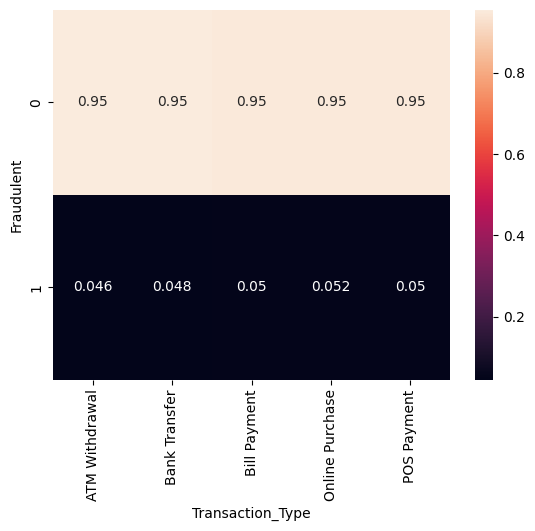

In [21]:
type_table = pd.pivot_table(fraud_df, index="Fraudulent", values="Transaction_ID", columns="Transaction_Type", aggfunc="count", observed=True)
type_table["ATM Withdrawal"] = type_table["ATM Withdrawal"]/(type_table["ATM Withdrawal"].sum())
type_table["Bank Transfer"] = type_table["Bank Transfer"]/(type_table["Bank Transfer"].sum())
type_table["Bill Payment"] = type_table["Bill Payment"]/(type_table["Bill Payment"].sum())
type_table["Online Purchase"] = type_table["Online Purchase"]/(type_table["Online Purchase"].sum())
type_table["POS Payment"] = type_table["POS Payment"]/(type_table["POS Payment"].sum())
sns.heatmap(type_table, annot=True)

<Axes: xlabel='Device_Used', ylabel='Fraudulent'>

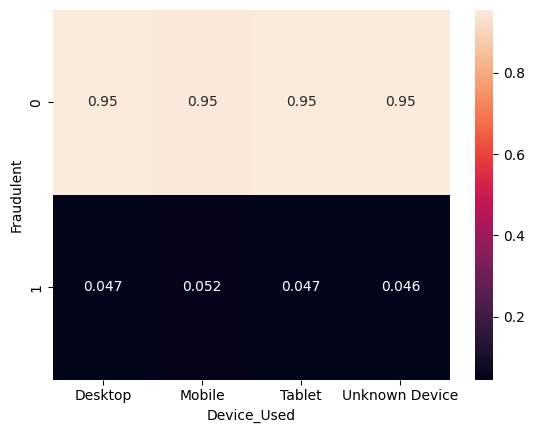

In [23]:
device_table = pd.pivot_table(fraud_df, index="Fraudulent", values="Transaction_ID", columns="Device_Used", aggfunc="count", observed=True)
for col in device_table.columns:
    device_table[col] = device_table[col]/device_table[col].sum()
sns.heatmap(device_table, annot=True)

<Axes: xlabel='Location', ylabel='Fraudulent'>

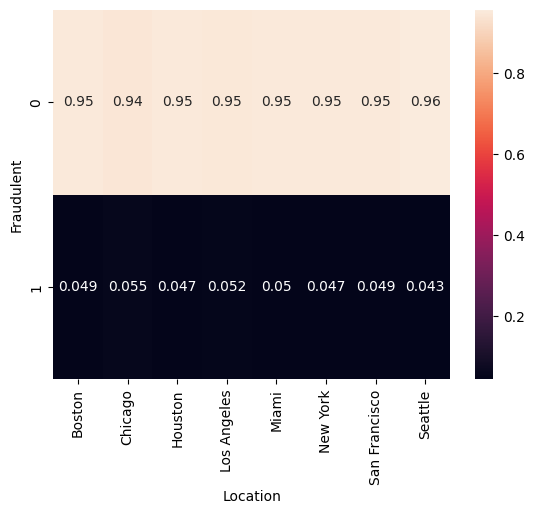

In [25]:
location_table = pd.pivot_table(fraud_df, index="Fraudulent", values="Transaction_ID", columns="Location", aggfunc="count", observed=True)
for col in location_table.columns:
    location_table[col] = location_table[col]/location_table[col].sum()
sns.heatmap(location_table, annot=True)

<Axes: xlabel='Payment_Method', ylabel='Fraudulent'>

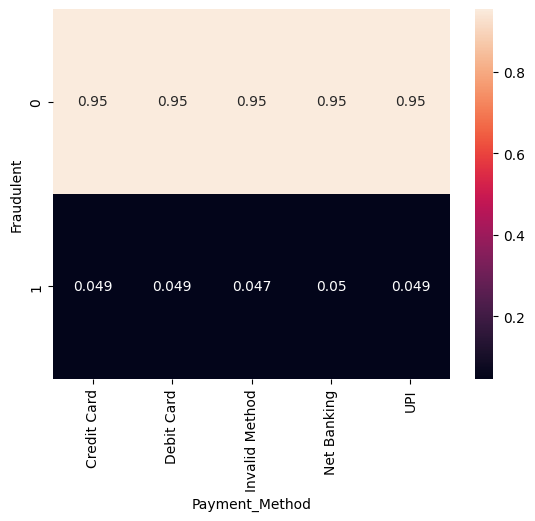

In [27]:
method_table = pd.pivot_table(fraud_df, index="Fraudulent", values="Transaction_ID", columns="Payment_Method", aggfunc="count", observed=False)
#type_table["ATM Withdrawal"] = type_table["ATM Withdrawal"]/(type_table["ATM Withdrawal"].sum())
for col in method_table.columns:
    method_table[col] = method_table[col]/method_table[col].sum()
sns.heatmap(method_table, annot=True)

Text(0.5, 1.0, 'Fraudulent Vs Transaction Amount')

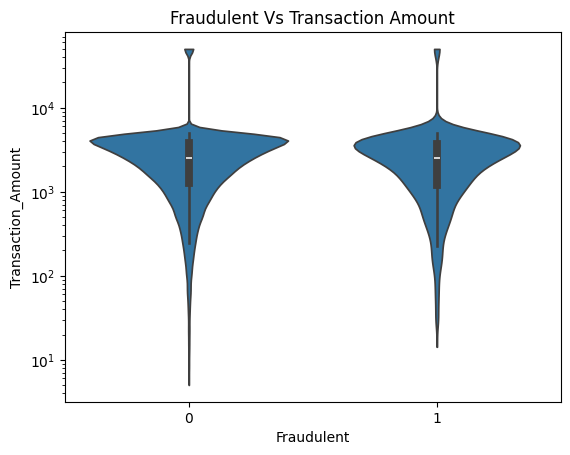

In [29]:
amount_plot = sns.violinplot(data=fraud_df, x="Fraudulent", y="Transaction_Amount",log_scale=True, cut=0)
amount_plot.set_title("Fraudulent Vs Transaction Amount")

### Statistical Testing

In [32]:
from pandas.core.dtypes.common import is_numeric_dtype

#Kruskal
#Transaction_Amount, Time_of_Transaction, Previous_Fraudulent_Transactions, Account_Age, Number_of_Transactions_Last_24H
#Chai Square
#Transaction_Type, Device_Used, Location, Payment_Method
X = ["Transaction_Amount", "Time_of_Transaction", "Previous_Fraudulent_Transactions", "Account_Age", "Number_of_Transactions_Last_24H", 
    "Transaction_Type", "Device_Used", "Location", "Payment_Method"]
var_name_above=[]
test_statistic_above=[]
p_values_above=[]
for col in X:
    if is_numeric_dtype(fraud_df[col]):
        samples_by_group = []
        for value in set(fraud_df["Fraudulent"]):
            mask_nulls = ~np.isnan(fraud_df[col])
            mask = fraud_df["Fraudulent"] == value
            samples_by_group.append(fraud_df[col][mask_nulls][mask])
        stat, p = kruskal(*samples_by_group)
        var_name_above.append(col)
        test_statistic_above.append(stat)
        p_values_above.append(p)
    else:
        combination_counts = pd.crosstab(fraud_df[col], fraud_df["Fraudulent"])
        chi2, p, _, _ = chi2_contingency(combination_counts)
        var_name_above.append(col)
        test_statistic_above.append(chi2)
        p_values_above.append(p)

In [34]:
p_values_above

[0.43203375919477693,
 0.06832904910695473,
 0.7264561203953033,
 0.18415349561700964,
 0.3937261153333802,
 0.35128119108864475,
 0.15976564000067062,
 0.15804015606346783,
 0.9891067711785603]

## Calculate na percantages for each column

In [37]:
nan_counts = 100*fraud_df.isna().sum()/len(fraud_df)
nan_counts

Transaction_ID                      0.000000
User_ID                             0.000000
Transaction_Amount                  4.973900
Transaction_Type                    0.000000
Time_of_Transaction                 5.049124
Device_Used                         0.000000
Location                            0.000000
Previous_Fraudulent_Transactions    0.000000
Account_Age                         0.000000
Number_of_Transactions_Last_24H     0.000000
Payment_Method                      0.000000
Fraudulent                          0.000000
Transaction_Amount_fill_mean        0.000000
Transaction_Amount_fill_median      0.000000
Transaction_Amount_fill_mode        0.000000
dtype: float64

Total nan count

In [40]:
total_nan = fraud_df.isna().any(axis=1).sum()
print(total_nan)
print(100*total_nan/len(fraud_df))

4286
9.769997036631791


## Bootstrap generator

In [ ]:
import random
rows = []
for i in range(len(fraud_df)):
    if random.randint(0,1) == 0:
        rows.append(fraud_df[fraud_df["Fraudulent"] == 0].sample(n=1))
    else:
        rows.append(fraud_df[fraud_df["Fraudulent"] == 1].sample(n=1))
bootstrap_df = pd.concat(rows)
bootstrap_df
#todo ask if they should be balanced probabilistically like this or perfectly (exactly half and half)

In [1]:
pd.concat(rows) 

NameError: name 'pd' is not defined

## Encoding categorical values as numbers

In [42]:
fraud_df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,Transaction_Amount_fill_mean,Transaction_Amount_fill_median,Transaction_Amount_fill_mode
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0,1292.76,1292.76,1292.76
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0,1554.58,1554.58,1554.58
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0,100.10,100.10,100.10
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0,1490.50,1490.50,1490.50
5,T6,2095,2372.04,ATM Withdrawal,15.0,Desktop,Boston,3,96,14,Credit Card,0,2372.04,2372.04,2372.04


Will dummy encode transaction_type, device_used, location, payment_method

In [45]:
fraud_df_encoded = pd.get_dummies(fraud_df, dtype = int, columns=['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method'])

In [47]:
# DataFrame after performing dummy Encoding
pd.set_option('display.max_columns', None)
fraud_df_encoded.head()

,Transaction_ID,User_ID,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent,Transaction_Amount_fill_mean,Transaction_Amount_fill_median,Transaction_Amount_fill_mode,Transaction_Type_ATM Withdrawal,Transaction_Type_Bank Transfer,Transaction_Type_Bill Payment,Transaction_Type_Online Purchase,Transaction_Type_POS Payment,Device_Used_Desktop,Device_Used_Mobile,Device_Used_Tablet,Device_Used_Unknown Device,Location_Boston,Location_Chicago,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Location_San Francisco,Location_Seattle,Payment_Method_Credit Card,Payment_Method_Debit Card,Payment_Method_Invalid Method,Payment_Method_Net Banking,Payment_Method_UPI
0,T1,4174,1292.76,16.0,0,119,13,0,1292.76,1292.76,1292.76,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,T2,4507,1554.58,13.0,4,79,3,0,1554.58,1554.58,1554.58,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,T4,2294,100.10,15.0,4,3,4,0,100.10,100.10,100.10,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,T5,2130,1490.50,19.0,2,57,7,0,1490.50,1490.50,1490.50,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
5,T6,2095,2372.04,15.0,3,96,14,0,2372.04,2372.04,2372.04,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


## PCA

**This is the dataframe that contains the encoded values, with non-needed columns dropped, and rows with null values removed.**

In [51]:
# drop non-needed columns
fraud_df_encoded.drop(inplace = True, axis=1, columns = ['Transaction_ID', 'User_ID'])

In [53]:
# need to drop NaNs for PCA to work
fraud_df_encoded.dropna(inplace = True, axis=0)

Trying PCA on all columns, didn't work well.

<Axes: >

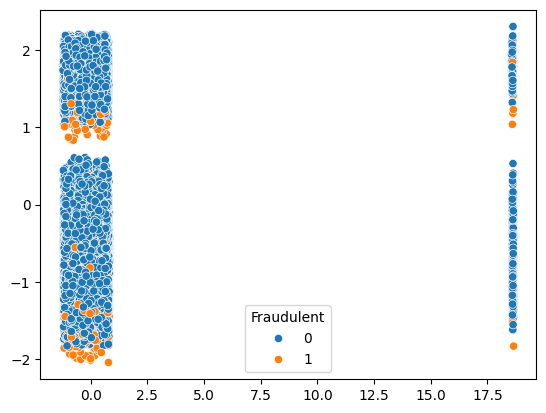

In [56]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# scale the data (good practice so outliers don't impact as much)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(fraud_df_encoded)
svd = TruncatedSVD(n_components = 2)

fraud_svd = svd.fit_transform(data_scaled)

# plot the pca
sns.scatterplot(y = fraud_svd[:,1], x = fraud_svd[:,0],  hue = fraud_df_encoded['Fraudulent']) # y is component 1, x is component 0 matrix[:,0]

Trying PCA on all original numerical columns.

<Axes: >

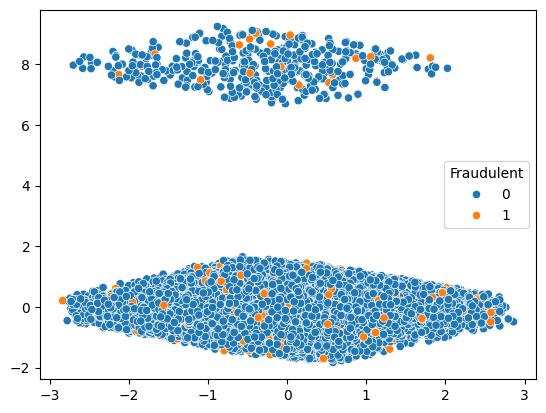

In [59]:
# NaNs should be dropped already if previous cell was ran

# scale the data (good practice so outliers don't impact as much)
scaler = StandardScaler()
data_scaled2 = scaler.fit_transform(fraud_df_encoded[['Transaction_Amount', 'Time_of_Transaction', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Number_of_Transactions_Last_24H']])
svd2 = TruncatedSVD(n_components = 2)

fraud_svd2 = svd2.fit_transform(data_scaled2)

# plot the pca
sns.scatterplot(y = fraud_svd2[:,1], x = fraud_svd2[:,0],  hue = fraud_df_encoded['Fraudulent']) # y is component 1, x is component 0 matrix[:,0]

### Data Modeling and prediction

In [62]:
#Using entire dataset

In [64]:
#train-test split
train, test = train_test_split(fraud_df_encoded, test_size = 0.30, stratify = fraud_df_encoded["Fraudulent"])
y_train = train["Fraudulent"]
x_train = train
del x_train["Fraudulent"]
y_test = test["Fraudulent"]
x_test = test
del x_test["Fraudulent"]

In [96]:
#scaling data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [148]:
#Logistic Regressor
lr_model = LogisticRegression().fit(x_train_scaled, y_train)
y_pred = lr_model.predict(x_test_scaled)
#accuracy = accuracy_score(y_test, y_pred)
#kfold_accuracy = cross_val_score(lr_model, x_test, y_test, cv=10)
#print("Logistic Regressor\n----------------------\nAccuracy: ", accuracy)
precision_score(y_test, y_pred)

C:\Users\munteand\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

In [150]:
#Decision tree
dt_model = DecisionTreeClassifier(random_state=0).fit(x_train, y_train)
y_pred = dt_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree\n----------------------\nAccuracy: ", accuracy)
np.unique(y_pred)
precision_score(y_test, y_pred)
recall_score(y_test, y_pred)

Decision Tree
----------------------
Accuracy:  0.8954947368421052


0.05756358768406961

In [154]:
#random forest
rf_model = RandomForestClassifier().fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest\n----------------------\nAccuracy: ", accuracy)
np.unique(y_pred)
precision_score(y_test, y_pred)
recall_score(y_test, y_pred)

Random Forest
----------------------
Accuracy:  0.9522526315789474


0.022413793103448276